In [2]:
# Import modules

import matplotlib.pyplot as plt
import os
from LaceyClass import LaceyMixingAnalyzer
from extrapolation import extrapolation

# Initialise variables and call class
simulation = os.path.abspath(os.path.join("..", '..', 'data', "rot_drum", "JKR_periodic_clean", "Rot_drum.dem"))
sim_path = os.path.dirname(simulation)

#simulation parameters
start_t = 1
end_t = 45
domain_x = (-0.06, 0.06)       
domain_y = (-0.015, 0.015)
domain_z = (-0.06, 0.06)
num_bins = 4
direction = "y"

extrap = extrapolation(start_t, end_t, simulation, domain_x, domain_y, domain_z, num_bins, direction)



Analysing Kinetic Energies...
[[ 24.           2.20006469   0.        ]
 [ 33.           3.10003512   0.89997043]
 [ 40.           3.80001211   0.699977  ]
 [ 49.           4.60005432   0.8000422 ]
 [ 56.           5.30003131   0.699977  ]
 [ 64.           6.10000503   0.79997371]
 [ 71.           6.80005052   0.70004549]
 [ 79.           7.60002423   0.79997371]
 [ 87.           8.30000123   0.699977  ]
 [ 95.           9.10004343   0.8000422 ]
 [103.           9.90001714   0.79997371]
 [110.          10.60006263   0.70004549]
 [118.          11.40003634   0.79997371]
 [125.          12.10001334   0.699977  ]
 [133.          12.90005554   0.8000422 ]
 [140.          13.60003254   0.699977  ]
 [148.          14.40000625   0.79997371]
 [156.          15.20004846   0.8000422 ]
 [163.          15.90002545   0.699977  ]
 [171.          16.70006766   0.8000422 ]
 [178.          17.40004465   0.699977  ]
 [188.          18.20001837   0.79997371]
 [196.          19.00006057   0.8000422 ]
 [20

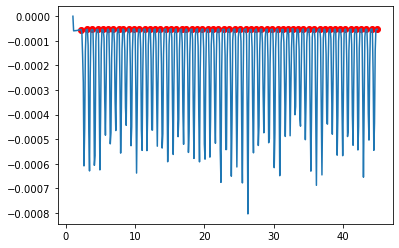

In [3]:
import numpy as np
kinetic_energies, peak_times, peak_index, highlight_y = extrap.kin_energies(0.0002, 5)
plt.figure()
plt.plot(extrap.deck.timestepValues[extrap.start:], kinetic_energies)
plt.scatter(peak_times, highlight_y, c="red")

time_diff_zeros = np.zeros_like(peak_times)
time_diff = np.diff(peak_times)
time_diff_zeros[1:] = time_diff
print(np.column_stack((peak_index, peak_times, time_diff_zeros)))

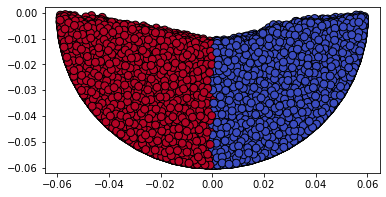

In [4]:
# Plot starting position

id_dict = extrap.id_dictionary(extrap.sim_time[0])
init_particles = extrap.get_particle_coords(extrap.sim_time[0])
plt.figure()
extrap.plot_particles(init_particles, id_dict, True)
plt.show()

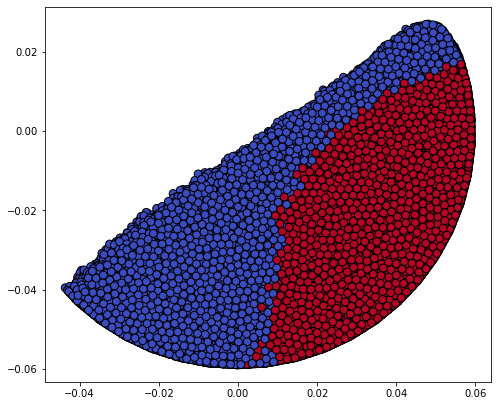

In [5]:
# Plot peak index 3 normal

plt.figure(figsize=(8,12))
actual_3 = extrap.plot_particles(extrap.get_particle_coords(peak_index[3]), id_dict, True)


In [6]:
extrap.deck.timestepValues[peak_index[49]]

39.60000007068532

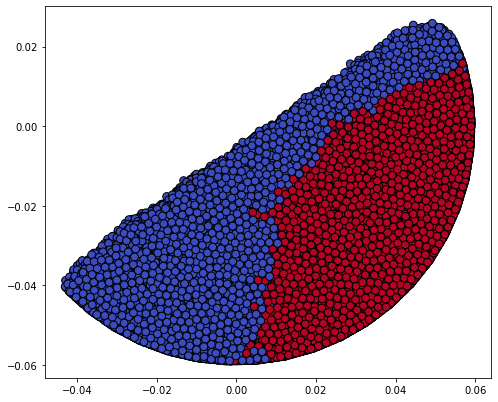

In [12]:
pos_dict_split = extrap.import_dict(sim_path, "peak_4y_split")
plt.figure(figsize=(8,12))
ex_3 = extrap.plot_particles(extrap.extrapolate_particles(extrap.get_particle_coords(peak_index[2]), pos_dict_split), id_dict, True)

21061


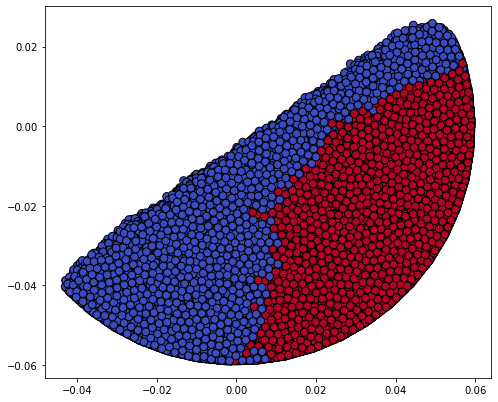

In [ ]:
pos_dict = extrap.import_dict(sim_path, "peak23")
print(len(pos_dict))

plt.figure(figsize=(8,12))
ex_3 = extrap.plot_particles(extrap.extrapolate_particles(extrap.get_particle_coords(peak_index[2]), pos_dict), id_dict, True)


In [ ]:
# Find keys with differing values
differing_entries = {key: (pos_dict_split[key], pos_dict[key]) for key in pos_dict_split if pos_dict_split[key] != pos_dict[key]}

print(f"{len(differing_entries)} different particle pairs ({len(differing_entries)/len(pos_dict)*100:.2f}%)")

2657 different particle pairs (12.62%)


In [ ]:
#get Lacey settings

with open(os.path.abspath(os.path.join("Lacey_settings.txt")), 'r') as file:
    preferences = file.readlines()
    minCoords = np.array([float(i) for i in str(preferences[1]).split(',')])
    maxCoords = np.array([float(i) for i in str(preferences[3]).split(',')])
    bins = np.array([int(i) for i in str(preferences[5]).split(',')])
    cut_off = float(preferences[7])
    plot = str(preferences[9])
    file.close()
    settings = True

lacey = LaceyMixingAnalyzer(minCoords, maxCoords, bins, simulation)

In [ ]:
Lacey_index = np.zeros(lacey.deck.numTimesteps)
b_coords, div_size = lacey.grid()
cut_off = 0.001

get_lacey = False

if get_lacey:
    for i in extrap.sim_time:
            particles = extrap.plot_particles(extrap.get_particle_coords(i), id_dict, 0)

            mass_1, mass_2, conc = lacey.bining(b_coords, div_size, particles, cut_off)

            Lacey_index[i] = lacey.Lacey(mass_1, mass_2, conc, cut_off, len(particles))
            print("Timestep: " + str(lacey.deck.timestepValues[i]) + " (s)")


            if i == extrap.sim_time[-1]: 
                if plot == 'yes\n':
                    time = lacey.deck.timestepValues
                    lacey.render(particles, b_coords, "test", Lacey_index, time, div_size, simulation)
                lacey.write_out(Lacey_index, time, simulation, "test")


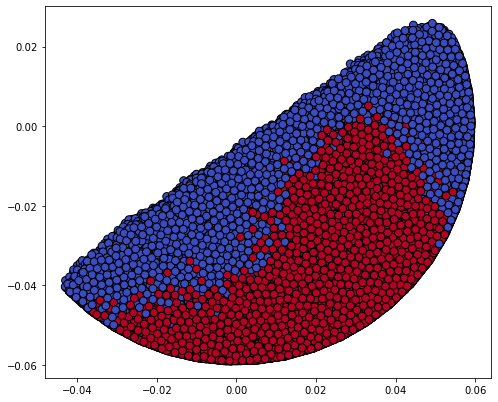

In [ ]:
predicted_old = extrap.plot_particles(extrap.get_particle_coords(peak_index[2]), id_dict, 0)
extrapolated_lacey = []
init_time = peak_times[2]
extrapolated_time = [init_time]
limit = 9


for i in range(limit):
    if i == limit-1:
        plt.figure(figsize=(8,12))
        predicted_new = extrap.plot_particles(extrap.extrapolate_particles(predicted_old, pos_dict), id_dict, 1)
        plt.show()
    else:
        predicted_new = extrap.plot_particles(extrap.extrapolate_particles(predicted_old, pos_dict), id_dict, 0)
        mass_1, mass_2, conc = lacey.bining(b_coords, div_size, predicted_new, cut_off)

        Lacey_index = lacey.Lacey(mass_1, mass_2, conc, cut_off, len(predicted_new))
        extrapolated_lacey.append(Lacey_index)
        new_time = extrapolated_time[-1]+0.8
        extrapolated_time.append(new_time)
        #print(Lacey_index, new_time)
        predicted_old = predicted_new

array([[ 2.03129832e-02, -1.40296662e-02, -5.33821587e-02, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 3.15713365e-02, -1.40287342e-02, -3.55608087e-02, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 5.78949641e-04, -1.40271400e-02, -5.55432343e-02, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 2.54213668e-02,  1.40282648e-02, -4.98271464e-02, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 2.33288070e-02,  1.40290749e-02, -3.96942719e-02, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.65299148e-02,  1.40310500e-02, -5.56706868e-02, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])

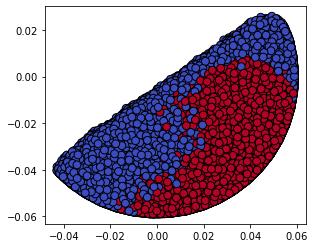

In [ ]:
extrap.plot_particles(extrap.extrapolate_particles(predicted_old, pos_dict), id_dict, 1)

In [ ]:
directory_path = sim_path

# Initialize an empty list to store the NumPy arrays
Lacey_actual = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('test_Report.csv'):  # Check if the file is a CSV file
        file_path = os.path.join(directory_path, filename)
        data = np.genfromtxt(file_path, delimiter=',', skip_header=0)  # Assuming CSV has headers
        Lacey_actual.append(data)

Lacey_actual = np.array(Lacey_actual)[0]

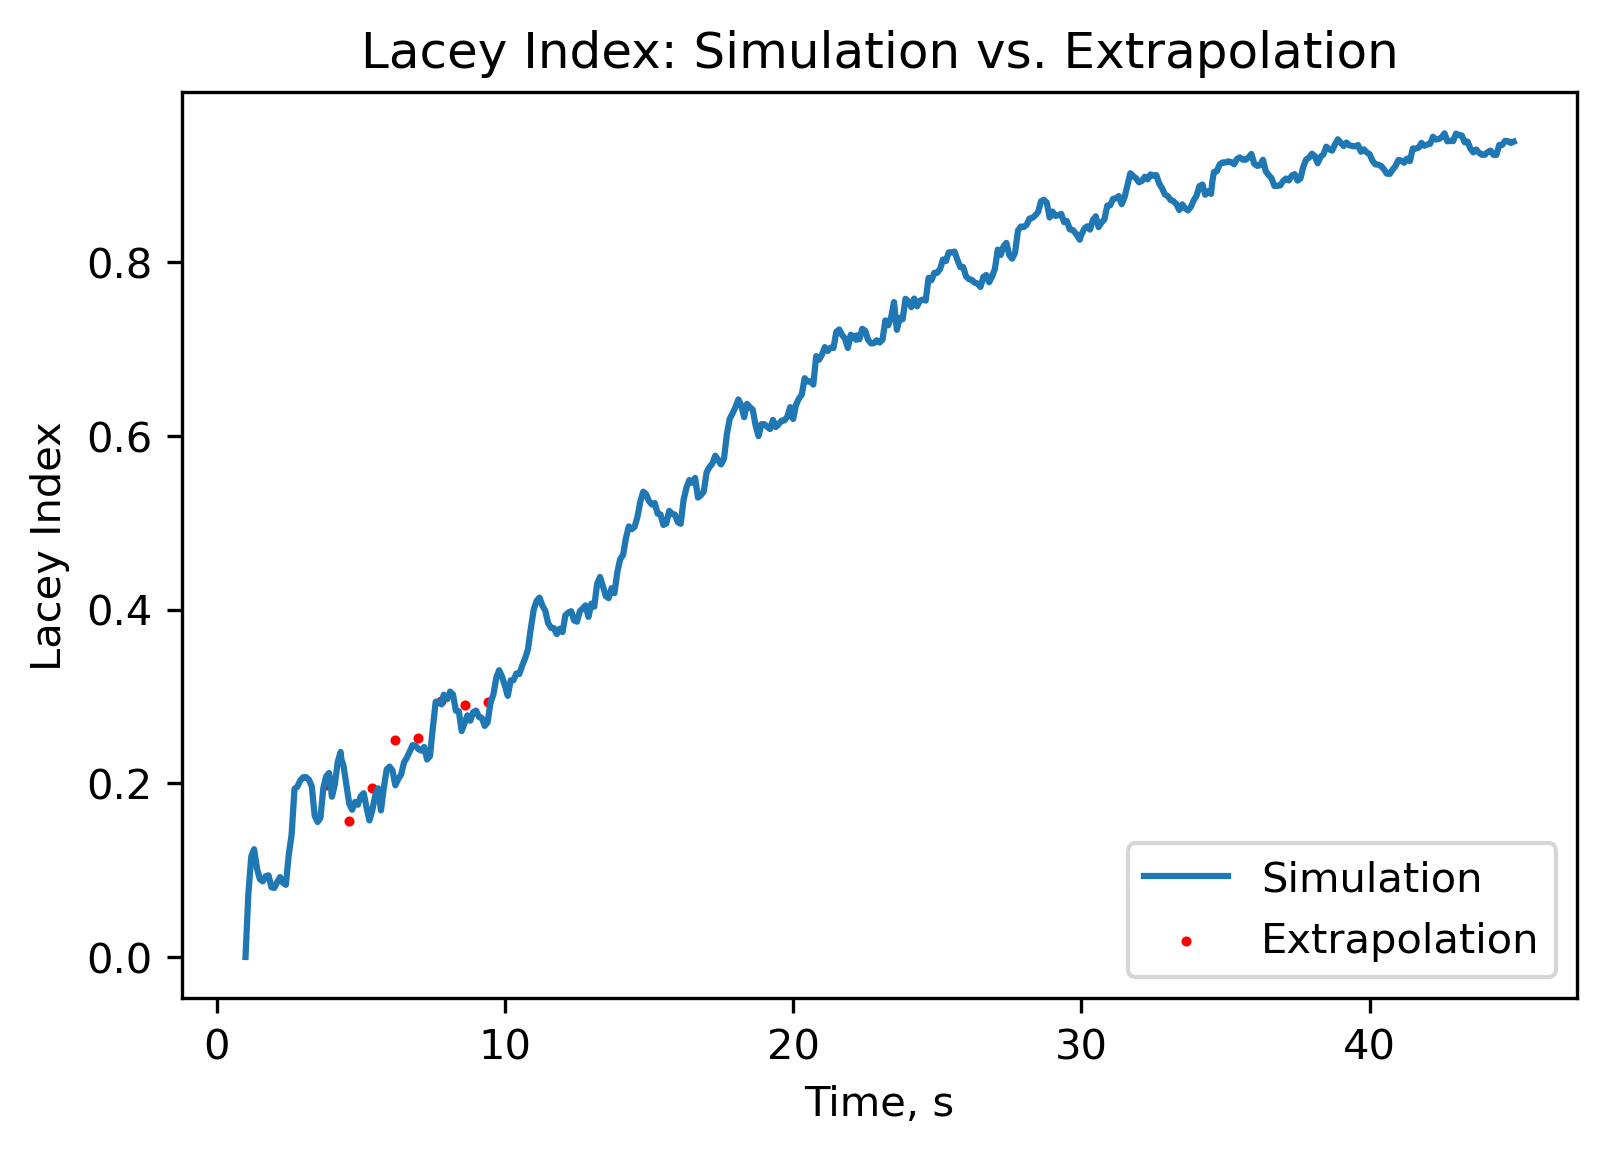

In [ ]:
plt.figure(dpi=300)
plt.plot(extrap.deck.timestepValues[extrap.start:], Lacey_actual[extrap.start:, 1], label = "Simulation")
plt.scatter(extrapolated_time[:-1], extrapolated_lacey, c="red", s=2, label = "Extrapolation")

plt.xlabel('Time, s')
plt.ylabel('Lacey Index')
plt.title('Lacey Index: Simulation vs. Extrapolation')
plt.legend(loc="lower right")